# Update 02

## Violence non-violence detection using MobileNetV2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import numpy as np
import os
import xml.etree.ElementTree as ET
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from google.colab.patches import cv2_imshow  # Import cv2_imshow for displaying images
import time
import seaborn as sns
# Define the path to the directory containing the JPG and XML files
train_directory_path = r'/content/drive/MyDrive/thesis/dataset/roboflow-cnn/train'
valid_directory_path = r'/content/drive/MyDrive/thesis/dataset/roboflow-cnn/valid'

# Define the batch size
batch_size = 32

# Define the input shape of the model
input_shape = (224, 224, 3)

# Load the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a custom output layer for bounding box regression (4 values)
x = base_model.output
x = Flatten()(x)
x = Dense(4, activation='linear')(x)  # 4 values for xmin, ymin, xmax, ymax
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
save_best = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/thesis/cnn_models/MobileNetV2Modelv1.h5", monitor='accuracy', save_best_only=True, verbose=1)

# Define a callback to track and print total training time and highest accuracy
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.start_time = None
        self.total_time = 0.0
        self.highest_train_acc = 0.0
        self.highest_val_acc = 0.0
        self.highest_train_epoch = 0
        self.highest_val_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        self.total_time += epoch_time
        print(f'Total training time for epoch {epoch + 1}: {epoch_time:.2f} seconds')

        train_acc = logs['accuracy']
        val_acc = logs['val_accuracy']

        if train_acc > self.highest_train_acc:
            self.highest_train_acc = train_acc
            self.highest_train_epoch = epoch + 1

        if val_acc > self.highest_val_acc:
            self.highest_val_acc = val_acc
            self.highest_val_epoch = epoch + 1

        print(f'Highest training accuracy: {self.highest_train_acc:.4f} at epoch {self.highest_train_epoch}')
        print(f'Highest validation accuracy: {self.highest_val_acc:.4f} at epoch {self.highest_val_epoch}')

# Define a data generator that yields batches of images and their corresponding annotations
def data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        train_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    train_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                             xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image and preprocess it
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    image = preprocess_input(image)
                    data.append(image)

                    # Yield the batch when the data and train_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(train_annotation)
                        data = []
                        train_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(train_annotation)

# Train the model with the timing callback
timing_callback = TimingCallback()
history = model.fit(data_generator(train_directory_path, batch_size, input_shape),
                    steps_per_epoch=len(os.listdir(train_directory_path)) // batch_size,
                    epochs=25,
                    verbose=1,
                    validation_data=data_generator(valid_directory_path, batch_size, input_shape),
                    validation_steps=len(os.listdir(valid_directory_path)) // batch_size,
                    callbacks=[save_best, timing_callback])

print(f'Total training time end of {len(history.epoch)} epochs: {timing_callback.total_time:.2f} seconds')

Epoch 1/25
123/123 [==============================] - ETA: 0s - loss: 1.4407 - accuracy: 0.4308
Epoch 1: accuracy improved from -inf to 0.43076, saving model to /content/drive/MyDrive/thesis/cnn_models/MobileNetV2Modelv1.h5
Total training time for epoch 1: 80.11 seconds
Highest training accuracy: 0.4308 at epoch 1
Highest validation accuracy: 0.5970 at epoch 1
123/123 [==============================] - 80s 319ms/step - loss: 1.4407 - accuracy: 0.4308 - val_loss: 17.0862 - val_accuracy: 0.5970
Epoch 2/25
123/123 [==============================] - ETA: 0s - loss: 0.1310 - accuracy: 0.7340
Epoch 2: accuracy improved from 0.43076 to 0.73400, saving model to /content/drive/MyDrive/thesis/cnn_models/MobileNetV2Modelv1.h5
Total training time for epoch 2: 39.98 seconds
Highest training accuracy: 0.7340 at epoch 2
Highest validation accuracy: 0.6220 at epoch 2
123/123 [==============================] - 40s 327ms/step - loss: 0.1310 - accuracy: 0.7340 - val_loss: 8.3514 - val_accuracy: 0.6220
Ep

### Plot the training and validation accuracy

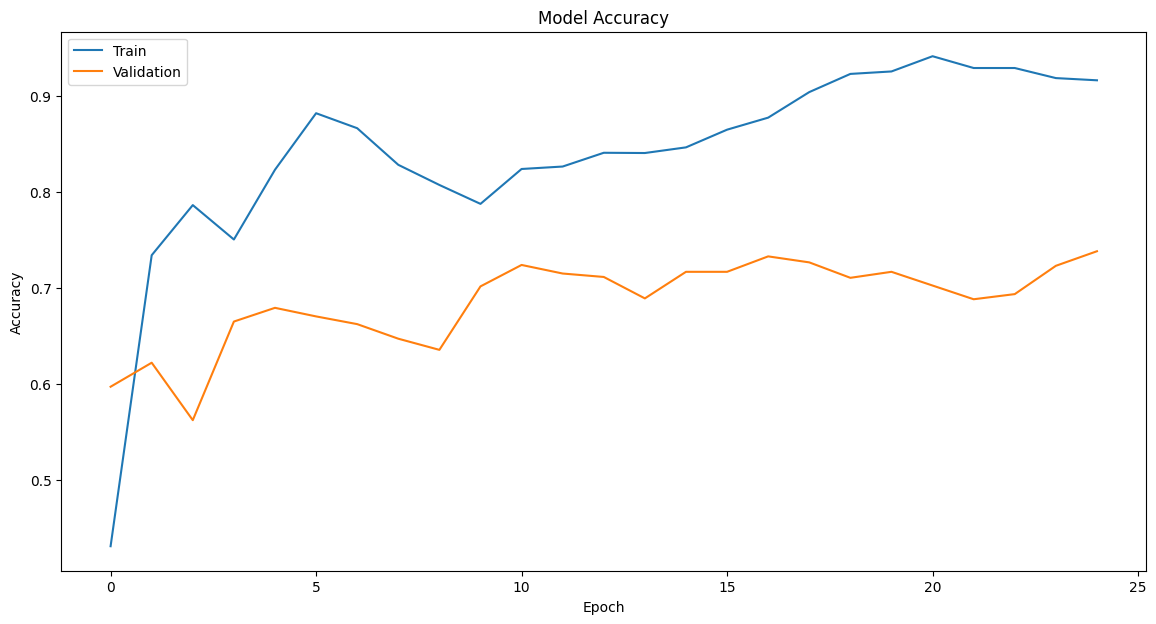

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plot the Training and Validation Loss

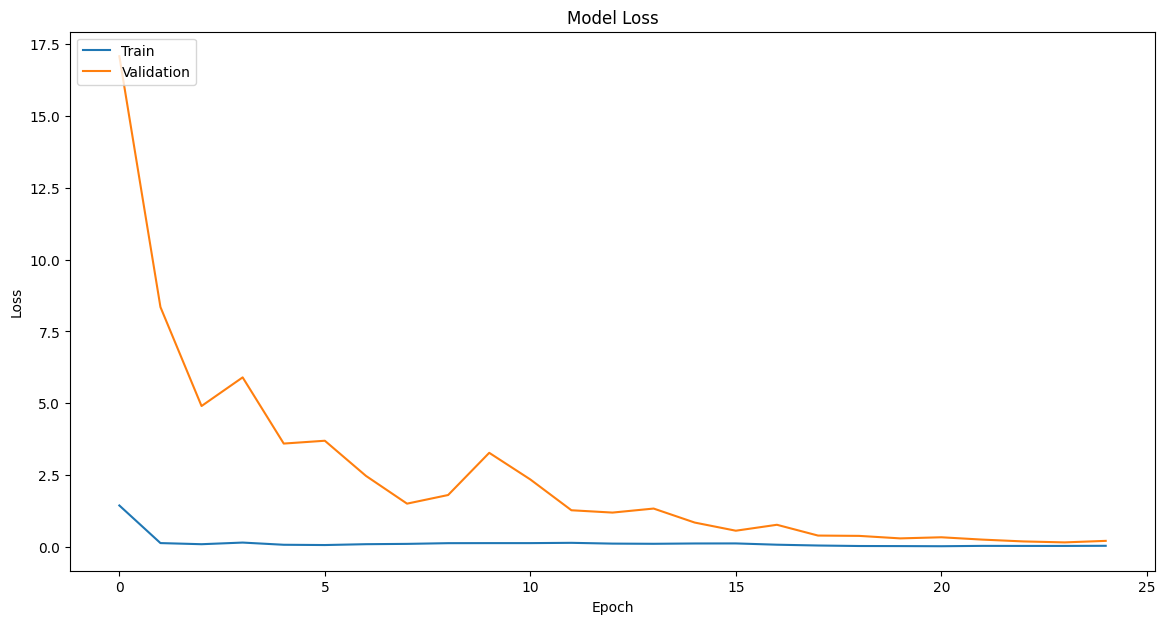

In [ ]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test dataset accuracy

In [ ]:
# Define the path to the test directory containing the JPG and XML files
test_directory_path = r'/content/drive/MyDrive/thesis/dataset/roboflow-cnn/test'

# Load the best saved model (or the model you want to evaluate)
model = tf.keras.models.load_model("/content/drive/MyDrive/thesis/cnn_models/MobileNetV2Modelv1.h5")

# Define a data generator for the test dataset
def test_data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        test_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    test_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                            xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image and preprocess it
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    image = preprocess_input(image)
                    data.append(image)

                    # Yield the batch when the data and test_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(test_annotation)
                        data = []
                        test_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(test_annotation)

# Evaluate the model on the test dataset
test_generator = test_data_generator(test_directory_path, batch_size, input_shape)
test_steps = len(os.listdir(test_directory_path)) // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

18/18 [==============================] - 5s 203ms/step - loss: 0.3391 - accuracy: 0.7106
Test Loss: 0.3391
Test Accuracy: 0.7106


### MSE MAE IoU result

In [ ]:
from sklearn.metrics import classification_report, average_precision_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the best saved model (or the model you want to evaluate)
model = tf.keras.models.load_model("/content/drive/MyDrive/thesis/cnn_models/MobileNetV2Modelv1.h5")

# Define a data generator for the test dataset
def test_data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        test_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    test_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                            xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image and preprocess it
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    image = preprocess_input(image)
                    data.append(image)

                    # Yield the batch when the data and test_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(test_annotation)
                        data = []
                        test_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(test_annotation)

# Evaluate the model on the test dataset
test_generator = test_data_generator(test_directory_path, batch_size, input_shape)
test_steps = len(os.listdir(test_directory_path)) // batch_size

# Get the predictions and true labels
y_true = []
y_pred = []

for i in range(test_steps):
    X_test, y_test = next(test_generator)
    y_true.extend(y_test.tolist())
    predictions = model.predict(X_test, verbose=0)
    y_pred.extend(predictions.tolist())

# Calculate the Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Calculate Intersection over Union (IoU) for each bounding box
def calculate_iou(box1, box2):
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    intersect_min_x = max(x1_min, x2_min)
    intersect_min_y = max(y1_min, y2_min)
    intersect_max_x = min(x1_max, x2_max)
    intersect_max_y = min(y1_max, y2_max)

    intersect_area = max(0, intersect_max_x - intersect_min_x + 1) * max(0, intersect_max_y - intersect_min_y + 1)

    box1_area = (x1_max - x1_min + 1) * (y1_max - y1_min + 1)
    box2_area = (x2_max - x2_min + 1) * (y2_max - y2_min + 1)

    iou = intersect_area / float(box1_area + box2_area - intersect_area)
    return iou

# Calculate the average IoU over all bounding boxes
iou_scores = [calculate_iou(box1, box2) for box1, box2 in zip(y_true, y_pred)]
average_iou = np.mean(iou_scores)
print("Average Intersection over Union (IoU):", average_iou)


Mean Squared Error (MSE): 0.3391415730768822
Mean Absolute Error (MAE): 0.4389191078122515
Average Intersection over Union (IoU): 0.45682938810196166


### Predict on test dataset images

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Define a data generator that yields batches of test images and their corresponding annotations
def test_data_generator(directory_path, batch_size, input_shape):
    while True:
        data = []
        test_annotation = []
        for filename in os.listdir(directory_path):
            if filename.endswith('.jpg'):
                # Extract the file path of the JPG image
                image_path = os.path.join(directory_path, filename)
                # Construct the file path of the corresponding XML annotation file
                xml_path = os.path.join(directory_path, filename[:-4] + '.xml')

                # Parse the XML annotation file
                tree = ET.parse(xml_path)
                root = tree.getroot()
                # Check if the bndbox element is present
                bndbox = root.find('object/bndbox')
                if bndbox is not None:
                    # Extract the bounding box coordinates
                    xmin = int(bndbox.find('xmin').text)
                    xmax = int(bndbox.find('xmax').text)
                    ymin = int(bndbox.find('ymin').text)
                    ymax = int(bndbox.find('ymax').text)
                    # Normalize the bounding box coordinates to the range [0, 1]
                    test_annotation.append([xmin / input_shape[0], ymin / input_shape[1],
                                            xmax / input_shape[0], ymax / input_shape[1]])

                    # Load the image
                    image = cv2.resize(cv2.imread(image_path), input_shape[:2])
                    data.append(image)

                    # Yield the batch when the data and test_annotation lists are of length batch_size
                    if len(data) == batch_size:
                        yield np.array(data), np.array(test_annotation)
                        data = []
                        test_annotation = []

        # Yield the last batch if it is smaller than batch_size
        if len(data) > 0:
            yield np.array(data), np.array(test_annotation)


# Load the saved model
model_path = '/content/drive/MyDrive/thesis/cnn_models/MobileNetV2Modelv1.h5'
Model = tf.keras.models.load_model(model_path)

# Define the path to the directory containing the test JPG files
test_directory_path = r'/content/drive/MyDrive/thesis/dataset/roboflow-cnn/test'

# Assuming you have 32 test samples, change this to the actual number of test samples
num_test_samples = 32

# Initialize the data generator for the test set
batch_size = 1  # Set the batch size for testing (you can adjust it as needed)
input_shape = (224, 224)  # Set the input shape based on the model's input requirements
# Get the list of image file names in the test directory
test_image_files = [filename for filename in os.listdir(test_directory_path) if filename.endswith('.jpg')]

test_generator = test_data_generator(test_directory_path, batch_size, input_shape)

# Loop through the test dataset and make predictions
for i in range(num_test_samples):
    images, annotations = next(test_generator)

    predictions = Model.predict(images)

    image = images[0].astype('uint8')  # Assuming batch size is 1
    annotation = annotations[0]
    pred = predictions[0]

    # Convert the normalized coordinates to pixel values for 224x224 input shape
    xmin, ymin, xmax, ymax = [int(anno * input_shape[i // 2]) for i, anno in enumerate(annotation)]
    xmin1, ymin1, xmax1, ymax1 = [int(p * input_shape[i // 2]) for i, p in enumerate(pred)]

    # Determine the class label based on the prediction score
    class_label = "Violence" if pred[0] > 0.5 else "NonViolence"

    # Set the color of the bounding box based on the class label
    box_color = (0, 255, 0)  # Green color for NonViolence
    if class_label == "Violence":
        box_color = (255, 0, 0)  # Red color for Violence

    cv2.rectangle(image, (xmin1, ymin1), (xmax1, ymax1), box_color, 2)
    cv2.putText(image, class_label, (xmin1, ymin1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)
    plt.imshow(image)
    plt.title('Prediction from MobileNetV2Modelv1')
    plt.show()

    box1 = [xmin, ymin, xmax, ymax]  # coordinates of the ground truth bounding box
    box2 = [xmin1, ymin1, xmax1, ymax1]  # coordinates of the predicted bounding box

    # Function to calculate the Intersection over Union (IoU)
    def calculate_iou(box1, box2):
        x5 = max(box1[0], box2[0])
        y5 = max(box1[1], box2[1])
        x6 = min(box1[2], box2[2])
        y6 = min(box1[3], box2[3])

        # calculate the area of intersection
        inter_area = max(0, x6 - x5) * max(0, y6 - y5)

        # calculate the area of union
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union_area = box1_area + box2_area - inter_area

        # calculate the IoU
        iou = inter_area / union_area
        return iou

    iou = calculate_iou(box1, box2)
    print(f"IoU for image {i+1}: {iou}")

Output hidden; open in https://colab.research.google.com to view.